# Insurance Claim Prediciton

In this notbook:
- loading data
- data prepration
- building feautre store
- building training set from FS
- build Pure Premium Modeling using AWS xgboost algo
- Model Explaibablity using FS data

What we can predict in this dataset?
1. __Claim Amount:__ total claims amount per policy holder.
1. __Claim Frequency:__ Number of claims per policy holder per exposure unit `Claim Frequency = Claim Count / Exposure`.
1. __Claim Severity:__ the average claim amount per claim for each policy holder per exposure unit `Claim Severity = Claim Cost / Claim Frequency`.
1. __Avg Claim amount:__ `Avg Claim amount = Claim Amount / Claim Count`
1. __Loss Cost:__ `Loss Cost = Claim Frequency x Claim Severity`
1. __Pure Premium:__ the mean of the total claim amount per exposure unit (the average loss per exposure) `PurePremium  = Claim Amount / Exposure`.

In [15]:
# !conda update scikit-learn -y
#!pip install -U scikit-learn

In [1]:
import sklearn
sklearn.__version__ 

'0.22.1'

In [2]:
print(__doc__)

from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import PoissonRegressor
from sklearn.linear_model import GammaRegressor
from sklearn.linear_model import TweedieRegressor
from sklearn.metrics import mean_tweedie_deviance
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer

from sklearn.metrics import mean_absolute_error, mean_squared_error, auc

Automatically created module for IPython interactive environment


ImportError: cannot import name 'PoissonRegressor' from 'sklearn.linear_model' (/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/__init__.py)

In [3]:
import boto3
import sagemaker
from sagemaker.session import Session


region = boto3.Session().region_name

boto_session = boto3.Session(region_name=region)

sagemaker_client = boto_session.client(service_name='sagemaker', region_name=region)
featurestore_runtime = boto_session.client(service_name='sagemaker-featurestore-runtime', region_name=region)

feature_store_session = Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_client,
    sagemaker_featurestore_runtime_client=featurestore_runtime
)

#### S3 Bucket Setup For The OfflineStore

SageMaker FeatureStore writes the data in the OfflineStore of a FeatureGroup to a S3 bucket owned by you. To be able to write to your S3 bucket, SageMaker FeatureStore assumes an IAM role which has access to it. The role is also owned by you.
Note that the same bucket can be re-used across FeatureGroups. Data in the bucket is partitioned by FeatureGroup.

Set the default s3 bucket name and it will be referenced throughout the notebook.

In [4]:
feature_store_session.default_bucket()

'sagemaker-us-east-1-079329190341'

In [5]:
# You can modify the following to use a bucket of your choosing
default_s3_bucket_name = feature_store_session.default_bucket()
prefix = 'sagemaker-featurestore-insurance'

print(default_s3_bucket_name)

sagemaker-us-east-1-079329190341


In [6]:
from sagemaker import get_execution_role

# You can modify the following to use a role of your choosing. See the documentation for how to create this.
role = get_execution_role()
print (role)

arn:aws:iam::079329190341:role/workshop-role


In [7]:
!aws s3 ls s3://sagemaker-us-east-1-079329190341/sagemaker-featurestore-insurance/079329190341/sagemaker/us-east-1/offline-store/insurance-policy-feature-group-06-20-23-32/

                           PRE data/
2021-02-06 21:03:42          0 insurance-policy-feature-group-06-20-23-322021-02-06T20:23:43.765Z.txt


Now let's wait for the data to appear in our offline store before moving forward to creating a dataset. This will take approximately 5 minutes.

In [8]:
list_of_FG =sagemaker_client.list_feature_groups()
insurance_policy_feature_group_name = list_of_FG['FeatureGroupSummaries'][-1]['FeatureGroupName']
insurance_policy_feature_group_name

'insurance-policy-feature-group-08-07-11-41'

In [9]:
from sagemaker.feature_store.feature_group import FeatureGroup

insurance_policy_feature_group = FeatureGroup(name=insurance_policy_feature_group_name, sagemaker_session=feature_store_session)

In [10]:
account_id = boto3.client('sts').get_caller_identity()["Account"]
print(account_id)

insurance_policy_feature_group_s3_prefix = prefix + '/' + account_id + '/sagemaker/' + region + '/offline-store/' + insurance_policy_feature_group_name + '/data'
print(insurance_policy_feature_group_s3_prefix)

079329190341
sagemaker-featurestore-insurance/079329190341/sagemaker/us-east-1/offline-store/insurance-policy-feature-group-08-07-11-41/data


In [11]:
prefix

'sagemaker-featurestore-insurance'

In [12]:
default_s3_bucket_name

'sagemaker-us-east-1-079329190341'

## Build Training Dataset

SageMaker FeatureStore automatically builds the Glue Data Catalog for FeatureGroups (you can optionally turn it on/off while creating the FeatureGroup). In this example, we want to create one training dataset with FeatureValues from both identity and transaction FeatureGroups. This is done by utilizing the auto-built Catalog. We run an Athena query that joins the data stored in the offline store in S3 from the 2 FeatureGroups. 

In [13]:
insurance_policy_query = insurance_policy_feature_group.athena_query()

insurance_policy_table = insurance_policy_query.table_name

query_string = 'SELECT * FROM "'+insurance_policy_table+'"' #+insurance_policy_table
print('Running ' + query_string)

# run Athena query. The output is loaded to a Pandas dataframe.
#dataset = pd.DataFrame()
insurance_policy_query.run(query_string=query_string, output_location='s3://'+default_s3_bucket_name+'/'+prefix+'/query_results/')
insurance_policy_query.wait()
dataset = insurance_policy_query.as_dataframe()

dataset

Running SELECT * FROM "insurance-policy-feature-group-08-07-11-41-1612768309"


,vehage_bin0_0_4_0,vehage_bin4_0_10_0,vehage_bin10_0_100_0,drivage_bin18_0_36_0,drivage_bin36_0_50_0,drivage_bin50_0_99_0,vehbrand_b1,vehbrand_b10,vehbrand_b11,vehbrand_b12,...,exposure,bonusmalus,claimamount,purepremium,frequency,avgclaimamount,eventtime,write_time,api_invocation_time,is_deleted
0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.30,90.0,0.0,0.0,0.0,0.0,1.612768e+09,2021-02-08 07:21:26.381,2021-02-08 07:16:26.000,False
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.00,50.0,0.0,0.0,0.0,0.0,1.612768e+09,2021-02-08 07:21:26.381,2021-02-08 07:16:26.000,False
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.00,80.0,0.0,0.0,0.0,0.0,1.612768e+09,2021-02-08 07:21:26.381,2021-02-08 07:16:26.000,False
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.00,50.0,0.0,0.0,0.0,0.0,1.612768e+09,2021-02-08 07:21:26.381,2021-02-08 07:16:26.000,False
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.60,50.0,0.0,0.0,0.0,0.0,1.612768e+09,2021-02-08 07:21:26.381,2021-02-08 07:16:26.000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.00,140.0,0.0,0.0,0.0,0.0,1.612768e+09,2021-02-08 07:14:44.011,2021-02-08 07:14:42.000,False
59996,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.00,80.0,0.0,0.0,0.0,0.0,1.612768e+09,2021-02-08 07:14:44.011,2021-02-08 07:14:42.000,False
59997,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.00,50.0,0.0,0.0,0.0,0.0,1.612768e+09,2021-02-08 07:14:44.011,2021-02-08 07:14:42.000,False
59998,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.47,95.0,0.0,0.0,0.0,0.0,1.612768e+09,2021-02-08 07:14:44.011,2021-02-08 07:14:42.000,False


In [14]:
# Prepare query results for training.
query_execution = insurance_policy_query.get_query_execution()
query_result = 's3://'+default_s3_bucket_name+'/'+prefix+'/query_results/'+query_execution['QueryExecution']['QueryExecutionId']+'.csv'
print(query_result)

s3://sagemaker-us-east-1-079329190341/sagemaker-featurestore-insurance/query_results/6e13c30e-7d17-4320-abda-f6023f94118b.csv


In [15]:
#!aws s3 ls s3://sagemaker-us-east-1-079329190341/sagemaker-featurestore-insurance/query_results/

In [16]:
df_features = pd.read_csv(query_result)

In [17]:
df_features.head()

,vehage_bin0_0_4_0,vehage_bin4_0_10_0,vehage_bin10_0_100_0,drivage_bin18_0_36_0,drivage_bin36_0_50_0,drivage_bin50_0_99_0,vehbrand_b1,vehbrand_b10,vehbrand_b11,vehbrand_b12,...,exposure,bonusmalus,claimamount,purepremium,frequency,avgclaimamount,eventtime,write_time,api_invocation_time,is_deleted
0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.3,90.0,0.0,0.0,0.0,0.0,1.612768e+09,2021-02-08 07:21:26.381,2021-02-08 07:16:26.000,False
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,50.0,0.0,0.0,0.0,0.0,1.612768e+09,2021-02-08 07:21:26.381,2021-02-08 07:16:26.000,False
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,80.0,0.0,0.0,0.0,0.0,1.612768e+09,2021-02-08 07:21:26.381,2021-02-08 07:16:26.000,False
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,50.0,0.0,0.0,0.0,0.0,1.612768e+09,2021-02-08 07:21:26.381,2021-02-08 07:16:26.000,False
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.6,50.0,0.0,0.0,0.0,0.0,1.612768e+09,2021-02-08 07:21:26.381,2021-02-08 07:16:26.000,False


In [19]:
df_features.columns

Index(['vehage_bin0_0_4_0', 'vehage_bin4_0_10_0', 'vehage_bin10_0_100_0',
       'drivage_bin18_0_36_0', 'drivage_bin36_0_50_0', 'drivage_bin50_0_99_0',
       'vehbrand_b1', 'vehbrand_b10', 'vehbrand_b11', 'vehbrand_b12',
       'vehbrand_b13', 'vehbrand_b14', 'vehbrand_b2', 'vehbrand_b3',
       'vehbrand_b4', 'vehbrand_b5', 'vehbrand_b6', 'vehpower_4_0',
       'vehpower_5_0', 'vehpower_6_0', 'vehpower_7_0', 'vehpower_8_0',
       'vehpower_9_0', 'vehpower_10_0', 'vehpower_11_0', 'vehpower_12_0',
       'vehpower_13_0', 'vehpower_14_0', 'vehpower_15_0', 'vehgas_diesel',
       'vehgas_regular', 'region_r11', 'region_r21', 'region_r22',
       'region_r23', 'region_r24', 'region_r25', 'region_r26', 'region_r31',
       'region_r41', 'region_r42', 'region_r43', 'region_r52', 'region_r53',
       'region_r54', 'region_r72', 'region_r73', 'region_r74', 'region_r82',
       'region_r83', 'region_r91', 'region_r93', 'region_r94', 'area_a',
       'area_b', 'area_c', 'area_d', 'area_e', 'a

In [30]:
feature_names

NameError: name 'feature_names' is not defined

In [20]:
#df_features.columns = feature_names +['PurePremium','Frequency','AvgClaimAmount','eventtime','write_time','api_invocation_time','is_deleted']

In [22]:
# Select useful columns for training with target column as the first.
dataset = df_features.iloc[:,np.r_[df_features.columns.get_loc('purepremium'), 0:60]]

# Write to csv in S3 without headers and index column.
dataset.to_csv('dataset.csv', header=False, index=False)
s3_client.upload_file('dataset.csv', default_s3_bucket_name, prefix+'/training_input/dataset.csv')
dataset_uri_prefix = 's3://'+default_s3_bucket_name+'/'+prefix+'/training_input/';

dataset

NameError: name 's3_client' is not defined

In [555]:
dataset.shape

(54274, 61)

# Pure Premium Modeling

#### Pure Premium Modeling using xgboost

In [91]:
training_image=sagemaker.image_uris.retrieve("xgboost", region, "1.0-1")
training_image

'683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.0-1-cpu-py3'

In [92]:
#!conda install -c conda-forge xgboost -y

In [93]:
training_output_path='s3://' + default_s3_bucket_name+'/'+prefix + '/training_output'

from sagemaker.estimator import Estimator
training_model = Estimator(training_image,
                           role, 
                           instance_count=1, 
                           instance_type='ml.m5.2xlarge',
                           volume_size = 5,
                           max_run = 3600,
                           input_mode= 'File',
                           output_path=training_output_path,
                           sagemaker_session=feature_store_session)

In [94]:
training_model.set_hyperparameters(objective = "reg:tweedie",
                                   num_round = 50)

In [95]:
train_data = sagemaker.inputs.TrainingInput(dataset_uri_prefix, distribution='FullyReplicated', 
                                            content_type='text/csv', s3_data_type='S3Prefix')
data_channels = {'train': train_data}

In [96]:
training_model.fit(inputs=data_channels, logs=True)

2021-02-08 17:49:44 Starting - Starting the training job...
2021-02-08 17:50:10 Starting - Launching requested ML instancesProfilerReport-1612806584: InProgress
.........
2021-02-08 17:51:31 Starting - Preparing the instances for training...
2021-02-08 17:52:15 Downloading - Downloading input data
2021-02-08 17:52:15 Training - Downloading the training image...
2021-02-08 17:52:43 Uploading - Uploading generated training model
2021-02-08 17:52:43 Completed - Training job completed
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:tweedie to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[17:52:31] 54274x60 matrix with 3256440 entries lo

## Set up Hosting for the Model

Once the training is done, we can deploy the trained model as an Amazon SageMaker real-time hosted endpoint. This will allow us to make predictions (or inference) from the model. Note that we don't have to host on the same instance (or type of instance) that we used to train. The endpoint deployment can be accomplished as follows. This takes 8-10 minutes to complete.

In [97]:
predictor = training_model.deploy(initial_instance_count = 1, instance_type = 'ml.m5.xlarge')

---------------!

## SageMaker FeatureStore During Inference

SageMaker FeatureStore can be useful in supplementing data for inference requests because of the low-latency GetRecord functionality. For this demo, we will be given a TransactionId and query our online FeatureGroups for data on the transaction to build our inference request. 


In [150]:
# Incoming inference request.
df_transformed['IDpol'][0:100]

0       1
1       3
2       5
3      10
4      11
     ... 
95    194
96    195
97    196
98    197
99    198
Name: IDpol, Length: 100, dtype: object

In [165]:
inference_request=[]
for IDpol in df_transformed['IDpol'][0:100]:
    #print(IDpol)
    IDpol = str(IDpol)
    transaction_response = featurestore_runtime.get_record(FeatureGroupName=insurance_policy_feature_group_name, RecordIdentifierValueAsString=IDpol)
    transaction_record = transaction_response['Record']
    testrecord = []
    for f in transaction_record:
        testrecord.append(f['ValueAsString'])
    inference_request.append(testrecord[0:60])

In [167]:
y_pred_xgboost=[]
import json
for inf_rec in inference_request:
    #print(inf_rec)
    results = predictor.predict(','.join(inf_rec), initial_args = {"ContentType": "text/csv"})
    y_pred_xgboost.append(json.loads(results))
print(y_pred_xgboost)

[80.57076263427734, 80.57076263427734, 78.45232391357422, 51.846824645996094, 51.846824645996094, 46.18067932128906, 46.18067932128906, 25.706512451171875, 25.706512451171875, 121.4596939086914, 121.4596939086914, 26.685638427734375, 10.480844497680664, 10.480844497680664, 77.1294174194336, 2.57491397857666, 14.66718864440918, 14.66718864440918, 30.639888763427734, 30.639888763427734, 30.639888763427734, 144.55230712890625, 144.55230712890625, 653.0926513671875, 1.1875756978988647, 1.1875756978988647, 1.1875756978988647, 147.79092407226562, 147.79092407226562, 147.79092407226562, 40.224456787109375, 72.23201751708984, 3.068223476409912, 3.068223476409912, 17.988035202026367, 17.988035202026367, 2.864704132080078, 2.864704132080078, 2.607928991317749, 2.607928991317749, 24.272960662841797, 24.272960662841797, 37.531524658203125, 37.531524658203125, 2.9021432399749756, 2.9021432399749756, 32.039146423339844, 32.039146423339844, 20.544235229492188, 28.82027816772461, 28.82027816772461, 1.

# Model Explaibablity
Gradient boosting can automatically provide estimates of feature importance from a trained predictive model. The more a feature is used to make key decisions with decision trees, the higher its relative importance.

A trained XGBoost model automatically calculates feature importance which are available in the __feature_importances___  variable of the trained model.

In [115]:
training_model.model_data

's3://sagemaker-us-east-1-079329190341/sagemaker-featurestore-insurance/training_output/sagemaker-xgboost-2021-02-08-17-49-44-142/output/model.tar.gz'

In [117]:
!tar -zxvf model.tar.gz

xgboost-model


In [120]:
import tarfile
import pickle as pkl

# download the model artifact from AWS S3
!aws s3 cp $training_model.model_data .

#opens the downloaded model artifcat and loads it as 'model' variable
tar = tarfile.open('model.tar.gz')
tar.extractall()
tar.close()


download: s3://sagemaker-us-east-1-079329190341/sagemaker-featurestore-insurance/training_output/sagemaker-xgboost-2021-02-08-17-49-44-142/output/model.tar.gz to ./model.tar.gz


In [123]:
!pip install xgboost

     |████████████████████████████████| 157.5 MB 48 kB/s s eta 0:00:01


In [124]:
import xgboost
model = pkl.load(open('xgboost-model', 'rb'))

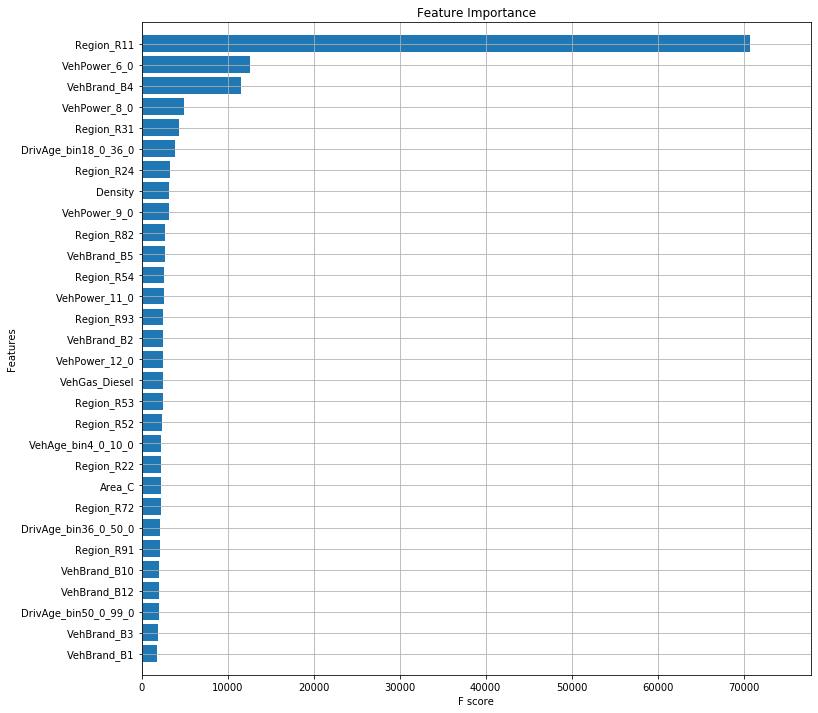

In [130]:
map_names = dict(zip(model.feature_names, df_features.columns[0:60]))
model.feature_names = list(map_names.values())

#plot feature importance
fig, ax = plt.subplots(figsize=(12,12))
xgboost.plot_importance(model, importance_type='gain', max_num_features=30, height=0.8, ax=ax, show_values = False)
plt.title('Feature Importance')
plt.show()

In [418]:
#model.get_score(importance_type='weight')

In [203]:
#!conda install -c conda-forge shap -y
import shap
shap_values = shap.TreeExplainer(model).shap_values(X_train)
#shap_values
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [419]:
#inference_request[0]

In [550]:
#test_ds = X_train[0:100]
test_ds = pd.DataFrame(data=inference_request, columns=test_ds.columns)[0:100]
for col in test_ds.columns:
    test_ds[col] = pd.to_numeric(test_ds[col])
from xgboost import DMatrix

model.predict(DMatrix(test_ds),output_margin=True)

array([ 4.3891363 ,  4.3891363 ,  4.362491  ,  3.9482942 ,  3.9482942 ,
        3.832562  ,  3.832562  ,  3.2467434 ,  3.2467434 ,  4.7995825 ,
        4.7995825 ,  3.2841244 ,  2.3495488 ,  2.3495488 ,  4.3454843 ,
        0.9458164 ,  2.685612  ,  2.685612  ,  3.422302  ,  3.422302  ,
        3.422302  ,  4.973642  ,  4.973642  ,  6.481719  ,  0.17191416,
        0.17191416,  0.17191416,  4.995799  ,  4.995799  ,  4.995799  ,
        3.6944752 ,  4.2798834 ,  1.1210997 ,  1.1210997 ,  2.8897064 ,
        2.8897064 ,  1.0524653 ,  1.0524653 ,  0.95855683,  0.95855683,
        3.1893618 ,  3.1893618 ,  3.6251812 ,  3.6251812 ,  1.0654497 ,
        1.0654497 ,  3.4669585 ,  3.4669585 ,  3.0225794 ,  3.3610785 ,
        3.3610785 ,  0.41454846,  0.41454846,  0.41454846,  1.2891662 ,
        1.2891662 ,  4.66793   ,  4.66793   , -1.0534524 , -1.0534524 ,
       -1.0534524 ,  4.7161393 ,  2.7285237 ,  2.7285237 ,  2.3281338 ,
        4.1664224 ,  5.9100313 ,  5.1693172 ,  4.209254  ,  4.20

- There is a transform between the margin of the model and the output of predict
- when output_margin is true, it outputs the raw untransformed margin value.

In [551]:
test_ds

,VehAge_bin0_0_4_0,VehAge_bin4_0_10_0,VehAge_bin10_0_100_0,DrivAge_bin18_0_36_0,DrivAge_bin36_0_50_0,DrivAge_bin50_0_99_0,VehBrand_B1,VehBrand_B10,VehBrand_B11,VehBrand_B12,...,Region_R91,Region_R93,Region_R94,Area_A,Area_B,Area_C,Area_D,Area_E,Area_F,Density
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.697199
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.697199
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.002238
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.815801
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.815801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.322898
96,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.516083
97,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.743170
98,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.630656


In [566]:
#Initialize your Jupyter notebook with initjs(), otherwise you will get an error message.
shap.initjs()

j=0
explainerModel = shap.TreeExplainer(model)
shap_values = explainerModel.shap_values(test_ds)
shap.force_plot(explainerModel.expected_value, shap_values[j,:], test_ds.iloc[j,:])

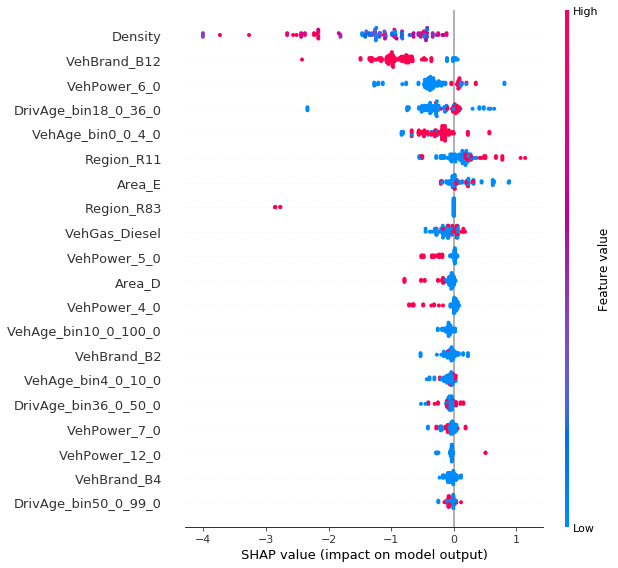

In [554]:
shap.summary_plot(shap_values, test_ds) 